In [1]:
import numpy as np 

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import stream
from torch.nn.utils.rnn import pad_sequence
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv, MetaLayer
from torch_scatter import scatter_mean

class PerceptionNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        fc_size = 16*(((((800-4)/2)-4)/2)**2)
        fc_size = int(fc_size)
        self.fc1 = nn.Linear(fc_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 64)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) #620944
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x 


In [4]:
def get_perception(problem_info):
    # import matplotlib.pyplot as plt 
    # plt.subplot(121)
    # plt.imshow(problem_info.perception['color'])
    # plt.title('Color image')
    # plt.subplot(122)
    # plt.imshow(np.squeeze(problem_info.perception['depth']))
    # plt.title('Depth image')
    # plt.savefig('/home/alex/drake-tamp/learning/gnn/test_rgbd_0.png')
    #TODO do clipping and normalization
    from numpy import inf 
    col = problem_info.perception['color'][:, :, :3]
    dep = problem_info.perception['depth'][:, :, ]
    dep[dep == inf] = np.max(dep[dep < 1000])
    perception = torch.from_numpy(np.concatenate((col, dep), axis=2))

    #normalizing
    input = torch.reshape(perception, (640000, 4))
    means = torch.mean(input, axis=0)
    std = torch.std(input, dim=0)
    normalized = (input - means)/std
    input = torch.reshape(normalized, (800, 800, 4))

    #reshaping to NCWH format for convolution 
    perception = input.permute(2, 0, 1)
    perception = perception.reshape([1, 4, 800, 800])
    return perception, input

In [5]:
import pickle

pik_file = "/home/alex/drake-tamp/experiments/jobs/random-rgbd/test/oracle/7_5_1_25.yaml_logs/2022-06-20-18:19:41.915_labels.pkl" 
with open(pik_file, "rb") as file:
    data = pickle.load(file)

perception, input = get_perception(data['problem_info'])


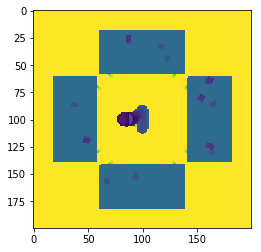

In [15]:
import matplotlib.pyplot as plt
small = torch.nn.functional.interpolate(perception, (200, 200))

plt.imshow(small[0][3])
plt.show()

In [193]:
net = PerceptionNetwork()
input.shape
net(input)
# plt.imshow((input).detach().numpy()[0, 3])
# plt.show()

tensor([[-0.0745,  0.0805, -0.0083,  0.0388, -0.0542,  0.1535,  0.0197,  0.0319,
         -0.0240, -0.0815, -0.0807,  0.0006, -0.0872,  0.0183,  0.0350,  0.1053,
         -0.0318,  0.0792,  0.0038,  0.0793, -0.0024,  0.0557,  0.0490,  0.0066,
         -0.0562, -0.0784, -0.0586,  0.0843,  0.0349, -0.1361,  0.1450,  0.0142,
          0.0186, -0.0084, -0.0249,  0.0684, -0.0560, -0.0593,  0.0535,  0.1066,
         -0.0300,  0.0677, -0.0286, -0.0819,  0.0078,  0.0822, -0.0560, -0.0264,
         -0.0637, -0.0313, -0.0550, -0.1186, -0.0226,  0.0880, -0.0729,  0.0315,
          0.0184,  0.0125, -0.0662, -0.0573, -0.0538, -0.1245,  0.0609,  0.0189]],
       grad_fn=<AddmmBackward>)